In [ ]:
# Check null percentages in enhanced_weather
null_percentages = enhanced_weather.apply(pd.isnull).sum()/weather.shape[0]
print("Null value percentages:")
print(null_percentages)
print("\nActual counts:")
print(enhanced_weather.apply(pd.isnull).sum())

# Weather Prediction Model

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

In [12]:
weather = pd.read_csv("pwm_weather.csv", index_col="DATE")

In [13]:
# give % of null values in each column
# weather.apply(pd.isnull).sum()/weather.shape[0]

In [14]:
#core data values noted by the NOAA
core_weather = weather[["PRCP","SNOW","SNWD","TMAX","TMIN"]].copy()

In [15]:
additional_features = ["AWND", "PSUN", "TAVG", "WDF2", "WSF2", "WDFG", "WSFG"]
enhanced_weather = weather[["PRCP","SNOW","SNWD","TMAX","TMIN"] + additional_features].copy()

In [11]:
core_weather.columns = ["precip", "snow", "snow_depth", "temp_max", "temp_min"]

In [13]:
core_weather.apply(pd.isnull).sum()/weather.shape[0]

precip        0.000042
snow          0.000542
snow_depth    0.005880
temp_max      0.000042
temp_min      0.000042
dtype: float64

In [8]:
# core_weather["snow_depth"].value_counts()

In [9]:
# core_weather[pd.isnull(core_weather["snow_depth"])]

In [18]:
core_weather["snow_depth"] = core_weather["snow_depth"].fillna(0)

In [19]:
core_weather[pd.isnull(core_weather["temp_max"])]

,precip,snow,snow_depth,temp_max,temp_min
DATE,,,,,
2025-08-24,NaN,NaN,0.0,NaN,NaN


In [22]:
core_weather = core_weather.ffill()

In [23]:
core_weather.apply(pd.isnull).sum()/weather.shape[0]

precip        0.0
snow          0.0
snow_depth    0.0
temp_max      0.0
temp_min      0.0
dtype: float64

In [24]:
core_weather.dtypes

precip        float64
snow          float64
snow_depth    float64
temp_max      float64
temp_min      float64
dtype: object

In [25]:
core_weather.index

Index(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04', '1960-01-05',
       '1960-01-06', '1960-01-07', '1960-01-08', '1960-01-09', '1960-01-10',
       ...
       '2025-08-15', '2025-08-16', '2025-08-17', '2025-08-18', '2025-08-19',
       '2025-08-20', '2025-08-21', '2025-08-22', '2025-08-23', '2025-08-24'],
      dtype='object', name='DATE', length=23978)

In [26]:
core_weather.index = pd.to_datetime(core_weather.index)

In [27]:
core_weather.index

DatetimeIndex(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04',
               '1960-01-05', '1960-01-06', '1960-01-07', '1960-01-08',
               '1960-01-09', '1960-01-10',
               ...
               '2025-08-15', '2025-08-16', '2025-08-17', '2025-08-18',
               '2025-08-19', '2025-08-20', '2025-08-21', '2025-08-22',
               '2025-08-23', '2025-08-24'],
              dtype='datetime64[ns]', name='DATE', length=23978, freq=None)

In [28]:
core_weather.index.year

Index([1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960,
       ...
       2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025],
      dtype='int32', name='DATE', length=23978)

In [29]:
core_weather.apply(lambda x: (x==9999).sum())

precip        0
snow          0
snow_depth    0
temp_max      0
temp_min      0
dtype: int64

<Axes: xlabel='DATE'>

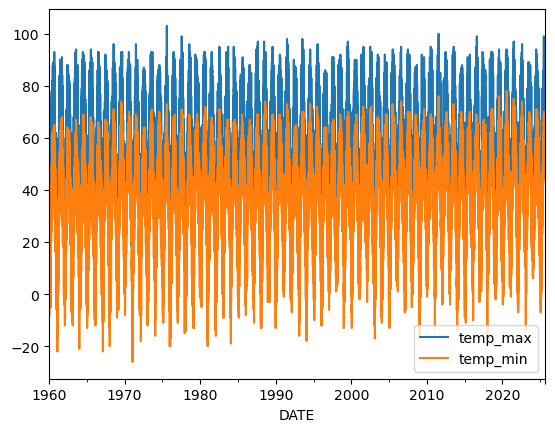

In [30]:
core_weather[["temp_max","temp_min"]].plot()

In [31]:
core_weather.index.year.value_counts().sort_index()

DATE
1960    366
1961    365
1962    365
1963    365
1964    366
       ... 
2021    365
2022    365
2023    365
2024    366
2025    236
Name: count, Length: 66, dtype: int64

<Axes: xlabel='DATE'>

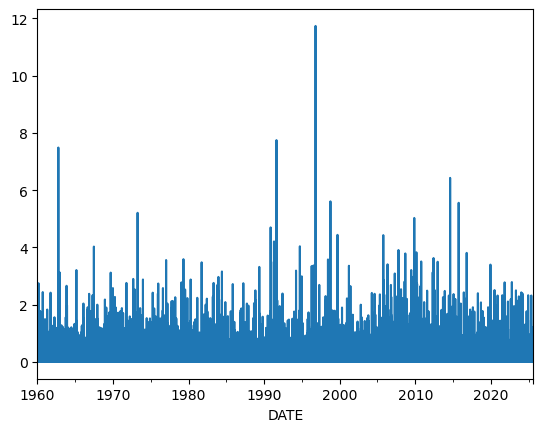

In [32]:
core_weather["precip"].plot()

In [35]:
# how much it __ each year
core_weather.groupby(core_weather.index.year).sum()

,precip,snow,snow_depth,temp_max,temp_min
DATE,,,,,
1960,43.21,94.0,719.0,20342.0,12668.0
1961,38.75,86.9,540.0,20158.0,12626.0
1962,46.33,81.2,672.0,19770.0,11946.0
1963,38.59,82.4,1163.0,20182.0,12028.0
1964,34.59,78.6,481.0,20232.0,12150.0
...,...,...,...,...,...
2021,44.92,33.4,246.3,21076.0,14675.0
2022,46.66,36.6,197.3,21051.0,14210.0
2023,56.67,52.5,375.2,20898.0,14818.0


In [37]:
#create column w tomorrow's temperature as "target" -> ensure prediction for tmrw's temp is based on prev data
core_weather["target"] = core_weather.shift(-1)["temp_max"]

In [38]:
core_weather

,precip,snow,snow_depth,temp_max,temp_min,target
DATE,,,,,,
1960-01-01,0.00,0.0,11.0,34.0,6.0,37.0
1960-01-02,0.00,0.0,9.0,37.0,0.0,48.0
1960-01-03,1.27,0.0,7.0,48.0,36.0,37.0
1960-01-04,0.00,0.0,1.0,37.0,27.0,33.0
1960-01-05,0.00,0.0,1.0,33.0,15.0,27.0
...,...,...,...,...,...,...
2025-08-20,0.03,0.0,0.0,67.0,51.0,71.0
2025-08-21,0.00,0.0,0.0,71.0,46.0,83.0
2025-08-22,0.00,0.0,0.0,83.0,50.0,82.0


In [43]:
# get rid of last row w/ NaN target
core_weather = core_weather.iloc[:-1,:].copy()

In [40]:
core_weather

,precip,snow,snow_depth,temp_max,temp_min,target
DATE,,,,,,
1960-01-01,0.00,0.0,11.0,34.0,6.0,37.0
1960-01-02,0.00,0.0,9.0,37.0,0.0,48.0
1960-01-03,1.27,0.0,7.0,48.0,36.0,37.0
1960-01-04,0.00,0.0,1.0,37.0,27.0,33.0
1960-01-05,0.00,0.0,1.0,33.0,15.0,27.0
...,...,...,...,...,...,...
2025-08-19,0.00,0.0,0.0,71.0,51.0,67.0
2025-08-20,0.03,0.0,0.0,67.0,51.0,71.0
2025-08-21,0.00,0.0,0.0,71.0,46.0,83.0


In [44]:
reg = Ridge(alpha = .1)

In [45]:
predictors = ["precip", "temp_max", "temp_min"]

In [46]:
train = core_weather.loc[:"2020-12-31"]

In [47]:
test = core_weather.loc["2021-01-01":]

In [48]:
reg.fit(train[predictors],train["target"])

Ridge(alpha=0.1)

In [49]:
predictions = reg.predict(test[predictors])

In [51]:
mean_absolute_error(test["target"],predictions)

5.788925798773943

In [55]:
# evaluating model by comparing actual vs prediction
combined = pd.concat([test["target"],pd.Series(predictions, index = test.index)], axis = 1)
combined.columns = ["actual","predictions"]

In [56]:
combined

,actual,predictions
DATE,,
2021-01-01,38.0,36.575989
2021-01-02,31.0,41.157857
2021-01-03,36.0,35.308081
2021-01-04,32.0,40.007745
2021-01-05,38.0,37.601726
...,...,...
2025-08-16,85.0,77.350879
2025-08-17,75.0,81.936250
2025-08-18,71.0,73.087349


<Axes: xlabel='DATE'>

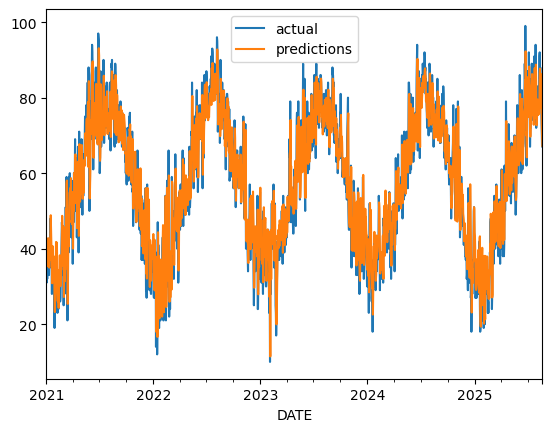

In [58]:
combined.plot()

In [59]:
reg.coef_

array([-0.74514766,  0.66471945,  0.27521331])

In [103]:
def create_predictions(predictors, core_weather, req):
    train = core_weather.loc[:"2020-12-31"]
    test = core_weather.loc["2021-01-01":]
    reg.fit(train[predictors],train["target"])
    predictions = reg.predict(test[predictors])
    error = mean_absolute_error(test["target"], predictions)                             
    combined = pd.concat([test["target"], pd.Series(predictions, index = test.index)], axis = 1)
    combined.columns = ["actual", "predictions"]
    return error, combined

In [104]:
# average temp of each month
core_weather["month_max"] = core_weather["temp_max"].rolling(30).mean()

In [105]:
core_weather

,precip,snow,snow_depth,temp_max,temp_min,target,month_max,month_day_max,max_min
DATE,,,,,,,,,
1960-06-29,0.00,0.0,0.0,77.0,60.0,82.0,NaN,0.957143,1.283333
1960-06-30,0.00,0.0,0.0,82.0,61.0,79.0,NaN,0.909756,1.344262
1960-07-01,0.00,0.0,0.0,79.0,56.0,79.0,NaN,0.952321,1.410714
1960-07-02,0.15,0.0,0.0,79.0,56.0,78.0,NaN,0.957384,1.410714
1960-07-03,0.40,0.0,0.0,78.0,52.0,74.0,NaN,0.972650,1.500000
...,...,...,...,...,...,...,...,...,...
2025-08-16,0.00,0.0,0.0,81.0,54.0,85.0,81.300000,1.003704,1.500000
2025-08-17,0.00,0.0,0.0,85.0,61.0,75.0,81.466667,0.958431,1.393443
2025-08-18,0.00,0.0,0.0,75.0,53.0,71.0,81.366667,1.084889,1.415094


In [143]:
core_weather = core_weather.iloc[30:,:].copy()

In [144]:
# difference for avg monthly temp vs temp in a given day
core_weather["month_day_max"] = core_weather["month_max"] / core_weather["temp_max"]

In [145]:
core_weather["range"] = core_weather["temp_max"] - core_weather["temp_min"]

In [146]:
core_weather["avg_temp"] = (core_weather["temp_max"] + core_weather["temp_min"]) / 2

In [147]:
core_weather["max_min"] = core_weather["temp_max"]/core_weather["temp_min"]

In [148]:
predictors = ["precip", "temp_max", "temp_min", "month_max", "month_day_max", "range", "avg_temp"]

In [149]:
core_weather

,precip,snow,snow_depth,temp_max,temp_min,target,month_max,month_day_max,max_min,range,avg_temp
DATE,,,,,,,,,,,
1960-08-28,0.00,0.0,0.0,85.0,47.0,88.0,77.866667,0.916078,1.808511,38.0,66.0
1960-08-29,0.04,0.0,0.0,88.0,51.0,81.0,78.500000,0.892045,1.725490,37.0,69.5
1960-08-30,0.05,0.0,0.0,81.0,59.0,80.0,78.533333,0.969547,1.372881,22.0,70.0
1960-08-31,0.00,0.0,0.0,80.0,52.0,87.0,78.633333,0.982917,1.538462,28.0,66.0
1960-09-01,0.00,0.0,0.0,87.0,55.0,74.0,78.666667,0.904215,1.581818,32.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-08-16,0.00,0.0,0.0,81.0,54.0,85.0,81.300000,1.003704,1.500000,27.0,67.5
2025-08-17,0.00,0.0,0.0,85.0,61.0,75.0,81.466667,0.958431,1.393443,24.0,73.0
2025-08-18,0.00,0.0,0.0,75.0,53.0,71.0,81.366667,1.084889,1.415094,22.0,64.0


In [151]:
core_weather.apply(np.isinf).sum()/weather.shape[0]

precip           0.00000
snow             0.00000
snow_depth       0.00000
temp_max         0.00000
temp_min         0.00000
target           0.00000
month_max        0.00000
month_day_max    0.00000
max_min          0.00392
range            0.00000
avg_temp         0.00000
dtype: float64

In [152]:
core_weather[core_weather["temp_max"] == 0]

,precip,snow,snow_depth,temp_max,temp_min,target,month_max,month_day_max,max_min,range,avg_temp
DATE,,,,,,,,,,,


In [154]:
# replace cell w/ temp_max val of 0 with the temp_max of the previous day
core_weather.loc[core_weather["temp_max"] == 0, "temp_max"] = (core_weather["temp_max"].shift())

In [155]:
core_weather[np.isinf(core_weather["month_day_max"])]

,precip,snow,snow_depth,temp_max,temp_min,target,month_max,month_day_max,max_min,range,avg_temp
DATE,,,,,,,,,,,


In [156]:
core_weather.apply(pd.isnull).sum()/weather.shape[0]

precip           0.0
snow             0.0
snow_depth       0.0
temp_max         0.0
temp_min         0.0
target           0.0
month_max        0.0
month_day_max    0.0
max_min          0.0
range            0.0
avg_temp         0.0
dtype: float64

In [157]:
error, combined = create_predictions(predictors, core_weather, reg)

In [158]:
error

5.5753514729282925

<Axes: xlabel='DATE'>

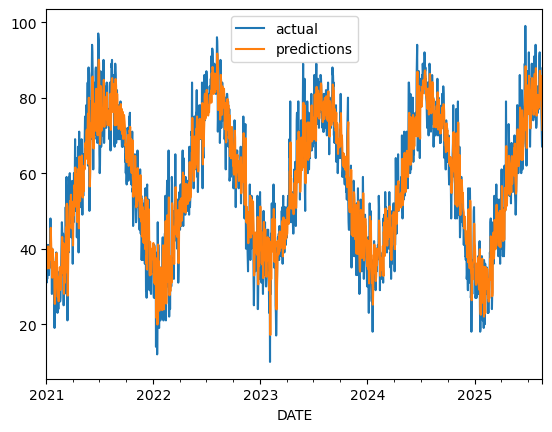

In [159]:
combined.plot()

In [163]:
# use previous rows temp in the same month to calc the mean for each day
core_weather["month_avg"] = (
    core_weather.groupby(core_weather.index.month)["temp_max"]
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
)

In [164]:
core_weather

,precip,snow,snow_depth,temp_max,temp_min,target,month_max,month_day_max,max_min,range,avg_temp,month_avg
DATE,,,,,,,,,,,,
1960-08-28,0.00,0.0,0.0,85.0,47.0,88.0,77.866667,0.916078,1.808511,38.0,66.0,85.000000
1960-08-29,0.04,0.0,0.0,88.0,51.0,81.0,78.500000,0.892045,1.725490,37.0,69.5,86.500000
1960-08-30,0.05,0.0,0.0,81.0,59.0,80.0,78.533333,0.969547,1.372881,22.0,70.0,84.666667
1960-08-31,0.00,0.0,0.0,80.0,52.0,87.0,78.633333,0.982917,1.538462,28.0,66.0,83.500000
1960-09-01,0.00,0.0,0.0,87.0,55.0,74.0,78.666667,0.904215,1.581818,32.0,71.0,87.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-16,0.00,0.0,0.0,81.0,54.0,85.0,81.300000,1.003704,1.500000,27.0,67.5,77.925649
2025-08-17,0.00,0.0,0.0,85.0,61.0,75.0,81.466667,0.958431,1.393443,24.0,73.0,77.929177
2025-08-18,0.00,0.0,0.0,75.0,53.0,71.0,81.366667,1.084889,1.415094,22.0,64.0,77.927717


In [168]:
core_weather["day_of_year_avg"] = core_weather["temp_max"].groupby(core_weather.index.day_of_year).transform(lambda x: x.expanding(1).mean())

In [169]:
predictors = ["precip", "temp_max", "temp_min", "month_max", "month_day_max", "range", "avg_temp", "month_avg", "day_of_year_avg"]

In [170]:
error, combined = create_predictions(predictors, core_weather, reg)

In [171]:
error

5.3089140651447115

In [172]:
reg.coef_

array([-0.24923328,  0.23871163,  0.12714527,  0.03719434, -0.43675512,
        0.11156636,  0.18292839,  0.16060731,  0.25189711])

In [173]:
core_weather.corr()["target"]

precip            -0.026510
snow              -0.229333
snow_depth        -0.461452
temp_max           0.907009
temp_min           0.873010
target             1.000000
month_max          0.866822
month_day_max     -0.241547
max_min           -0.096797
range              0.180109
avg_temp           0.908958
month_avg          0.887357
day_of_year_avg    0.898371
Name: target, dtype: float64

In [175]:
combined["diff"] = (combined["actual"] - combined["predictions"]).abs()

In [176]:
combined.sort_values("diff", ascending = False).head()

,actual,predictions,diff
DATE,,,
2025-04-18,79.0,53.507175,25.492825
2022-02-22,66.0,43.193423,22.806577
2021-12-10,56.0,33.276091,22.723909
2023-06-02,55.0,77.642986,22.642986
2022-01-16,47.0,24.878443,22.121557
